# **Import Libraries**

In [20]:
import os
import re
import numpy as np
import pandas as pd
import pickle
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input , Dense , Embedding , LSTM , Dropout , add
from nltk.translate.bleu_score import corpus_bleu 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'

# **Extract Image Features**

In [3]:
# Load pretrained model
feature_extractor = VGG16()
# Restructure the model
feature_extractor = Model(inputs = feature_extractor.inputs, outputs = feature_extractor.layers[-2].output)

feature_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
    # Preprocess image for vgg
    image = preprocess_input(image)
    # Extract features
    feature = feature_extractor.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    features[image_id] = feature.squeeze()

print(f"Extracted features for {len(features)} images.")

  0%|          | 0/8091 [00:00<?, ?it/s]

Extracted features for 8091 images.


In [5]:
# Store features in pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [6]:
# Load features from pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as file:
    features = pickle.load(file)

# **Load captions and preprocessing**

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions = f.read()

In [8]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions.split('\n')):
    # Split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert capion list to string
    caption = ' '.join(caption)
    # Check for image id 
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
# Show samples
for image_id in list(mapping.keys())[:2]:
    print(image_id)
    print('\n'.join(mapping[image_id]))
    print('-'*50)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
--------------------------------------------------
1001773457_577c3a7d70
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
--------------------------------------------------


In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# Perform cleaning
clean(mapping)

In [12]:
# Show sample 
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
captions = [caption for key in mapping for caption in mapping[key]]
len(captions)

40455

In [14]:
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# Tokenize the text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f'The length of vocab is {vocab_size}')

The length of vocab is 8485


In [16]:
# get maximum length 
max_length = max(len(caption.split()) for caption in captions)
max_length

35

# **Split the dataset**

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# **Data Generator**

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # Tokenize the caption
                sequence = tokenizer.texts_to_sequences([caption])[0]
                # Split into input-output pairs
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode output
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store
                    X1.append(features[key])
                    X2.append(in_seq)
                    y.append(out_seq)
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

# **Model**

In [30]:
# Encode 
# Image features layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2 ,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 35, 256)        │      2,172,160 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 4096)           │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 35, 256)        │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 35)             │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │      1,048,832 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 256)            │        525,312 │ dropout_9[0][0],       │
│                           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ dense_8[0][0],         │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │         65,792 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 8485)           │      2,180,645 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

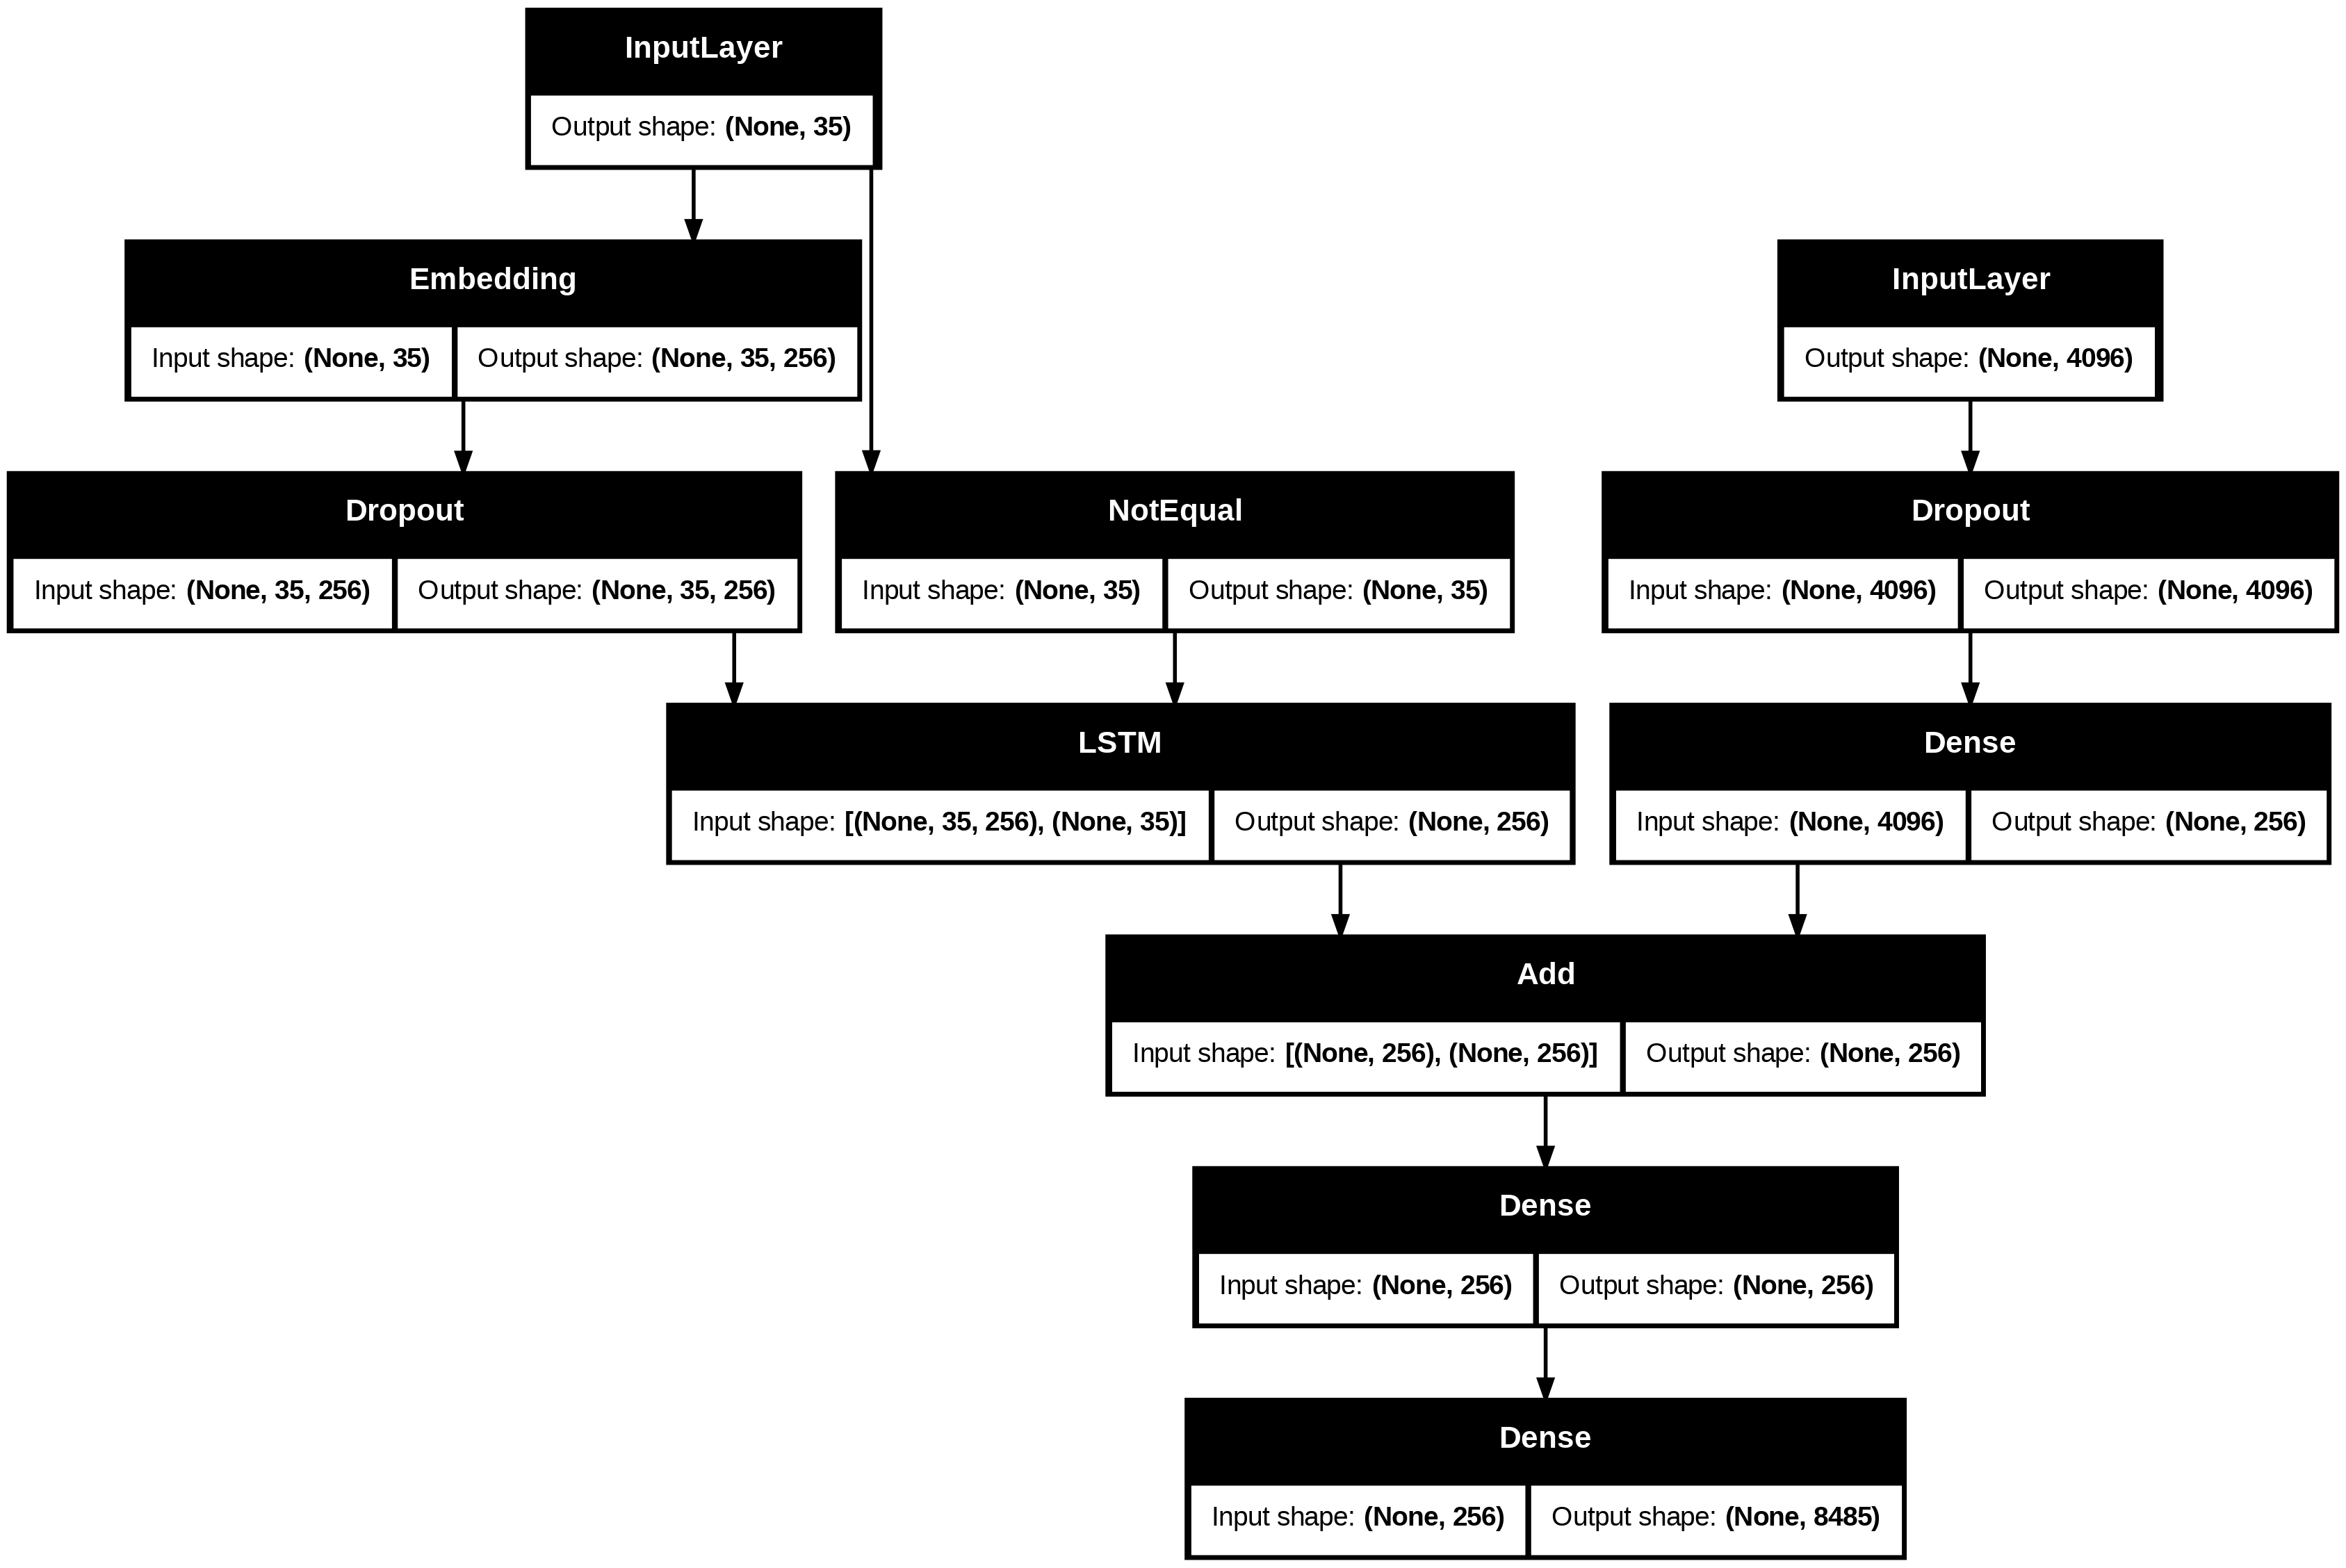

In [31]:
# Plot the model
plot_model(model, show_shapes = True)

In [32]:
# Define the output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

# Create dataset function
def create_dataset(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )
    return dataset

In [33]:
# Training parameters
epochs = 30
batch_size = 32
steps = len(train) // batch_size

# Create and train
train_dataset = create_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - loss: 5.7827
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - loss: 4.0794
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 47s 205ms/step - loss: 3.6004
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 3.3181
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 3.1112
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.9541
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.8407
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - loss: 2.7496
Epoch 9/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.6671
Epoch 10/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.5965
Epoch 11/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.5311
Epoch 12/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - loss: 2.4743
Epoch 13/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.4235
Epoch 14/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.3780
Epoch 15/30
227

In [34]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

# **Evaluation**

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
def predict_caption(model, image, tokenizer, max_length):
    # Add batch dimension to image features
    image = np.expand_dims(image, axis=0)  # Shape: (1, 4096)
    
    # Start with 'startseq'
    in_text = 'startseq'
    for i in range(max_length):
        # Encode and pad the sequence (right-padding)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post') 
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0) 
        yhat = np.argmax(yhat)
        
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        
        # Append word to input text
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [39]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.531863
BLEU-2: 0.301961


In [40]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man in black jacket and green sunglasses stands next to skyscraper endseq


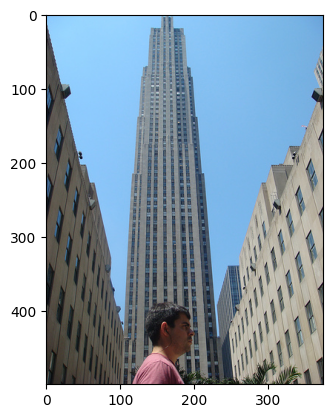

In [42]:
generate_caption('1032460886_4a598ed535.jpg')

---------------------Actual---------------------
startseq man in black is sitting next to modern art structure in front of glass building endseq
startseq man sits and reads newspaper by sculpture outside of an office building endseq
startseq man sits near large statue endseq
startseq man sitting in front of metal sculpture in front of building endseq
startseq the man with the backpack is sitting in buildings courtyard in front of an art sculpture reading endseq
--------------------Predicted--------------------
startseq man in black sits on the grass reading newspaper endseq


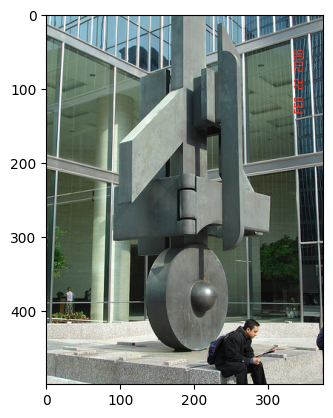

In [43]:
generate_caption('103195344_5d2dc613a3.jpg')

In [44]:
def predict_caption_beam_search(model, image, tokenizer, max_length, beam_width=3):
    # Add batch dimension to image features
    image = np.expand_dims(image, axis=0)  # Shape: (1, 4096)
    
    # Initialize the beam: list of (sequence, log_prob) tuples
    start_seq = tokenizer.texts_to_sequences(['startseq'])[0]  # Convert 'startseq' to index
    initial_beam = [(start_seq, 0.0)]  # Start with log probability 0
    
    # Store completed sequences
    completed_sequences = []
    
    for _ in range(max_length):
        # Temporary storage for new candidates
        all_candidates = []
        
        # Expand each sequence in the current beam
        for seq, log_prob in initial_beam:
            # If sequence ends with 'endseq', move to completed
            if seq[-1] == tokenizer.word_index.get('endseq', -1):
                completed_sequences.append((seq, log_prob))
                continue
                
            # Pad sequence for prediction (right-padding for cuDNN compatibility)
            padded_seq = pad_sequences([seq], maxlen=max_length, padding='post')  # Shape: (1, max_length)
            
            # Predict probabilities for the next word
            probs = model.predict([image, padded_seq], verbose=0)[0]  # Shape: (vocab_size,)
            
            # Get top k words based on probability
            top_k_indices = np.argsort(probs)[-beam_width:]  # Indices of top k probabilities
            top_k_probs = probs[top_k_indices]  # Corresponding probabilities
            
            # Create new candidate sequences
            for i, prob in zip(top_k_indices, top_k_probs):
                new_seq = seq + [i]  # Append the new word index
                new_log_prob = log_prob + np.log(prob + 1e-10)  # Add log probability (avoid log(0))
                all_candidates.append((new_seq, new_log_prob))
        
        # Sort all candidates by log probability and keep top k
        all_candidates.sort(key=lambda x: x[1], reverse=True)  # Sort by log_prob descending
        initial_beam = all_candidates[:beam_width]  # Keep top beam_width candidates
        
        # If no candidates remain (all ended), break
        if not initial_beam:
            break
    
    # Add remaining beams to completed sequences
    completed_sequences.extend(initial_beam)
    
    # Sort completed sequences by log probability
    completed_sequences.sort(key=lambda x: x[1], reverse=True)
    
    # Convert the best sequence to text
    if not completed_sequences:
        return "startseq"  # Fallback if no sequence is generated
    best_seq = completed_sequences[0][0]  # Take the sequence with highest log_prob
    
    # Convert indices to words
    caption = []
    for idx in best_seq:
        word = idx_to_word(idx, tokenizer)
        if word and word not in ['startseq', 'endseq']:
            caption.append(word)
        elif word == 'endseq':
            break
    
    return " ".join(caption)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
two dogs are fighting in field


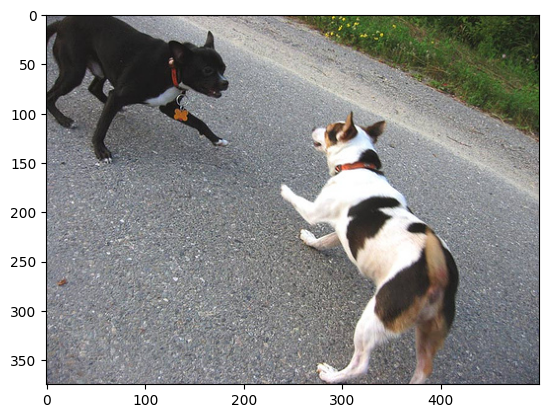

In [45]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predict with beam search
    y_pred = predict_caption_beam_search(model, features[image_id], tokenizer, max_length, beam_width=3)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.show()

# Test it
generate_caption("1001773457_577c3a7d70.jpg")